In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import cv2
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import time

from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression

In [2]:
vgg_model = vgg16(weights=VGG16_Weights.IMAGENET1K_FEATURES)

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [4]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
#remove classifier
#reference: https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648
vgg_model.classifier = Identity()

In [6]:
vgg_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
#  224x224
vgg_16_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

tensor([[1.7088, 0.6674, 1.4362,  ..., 0.2270, 0.1163, 0.0433],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0930, 0.1343,  ..., 0.7498, 1.0987, 0.1352],
        ...,
        [0.0000, 0.0310, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0969, 0.4956, 0.3838,  ..., 1.0123, 0.5141, 0.7073],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReshapeAliasBackward0>)

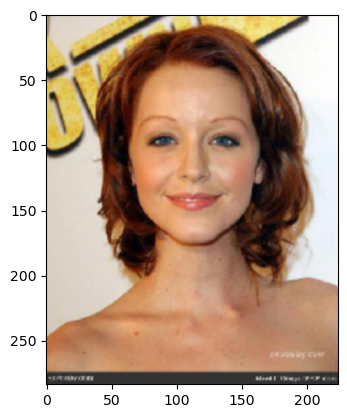

In [8]:
sample_img = Image.open('152018.jpg')
sample_img = vgg_16_transform(sample_img)
plt.imshow(transforms.ToPILImage()(sample_img), interpolation="bicubic")

sample_output = vgg_model(sample_img)
sample_output

In [9]:
folders = ['2--Demonstration', '6--Funeral', '10--People_Marching', '14--Traffic', '18--Concerts', '22--Picnic', '26--Soldier_Drilling', '30--Surgeons', '34--Baseball', '38--Tennis', '42--Car_Racing', '46--Jockey', '50--Celebration_Or_Party', '54--Rescue', '58--Hockey', 'img_celeba_102', 'img_celeba_103', 'img_celeba_104', 'img_celeba_105', 'img_celeba_106', 'img_celeba_107', 'img_celeba_108', 'img_celeba_109', 'img_celeba_110', 'img_celeba_111', 'img_celeba_112', 'img_celeba_113', 'img_celeba_114', 'img_celeba_115', 'img_celeba_116', 'img_celeba_117', 'img_celeba_118', 'img_celeba_119', 'img_celeba_120', 'img_celeba_121', 'img_celeba_122', 'img_celeba_123', 'img_celeba_124', 'img_celeba_125', 'img_celeba_126', 'img_celeba_127', 'img_celeba_128', 'img_celeba_129', 'img_celeba_130', 'img_celeba_131', 'img_celeba_132', 'img_celeba_133', 'img_celeba_134', 'img_celeba_135', 'img_celeba_136', 'img_celeba_137', 'img_celeba_138', 'img_celeba_139', 'img_celeba_140', 'img_celeba_141', 'img_celeba_142', 'img_celeba_143', 'img_celeba_144', 'img_celeba_145', 'img_celeba_146', 'img_celeba_147', 'img_celeba_148', 'img_celeba_149', 'img_celeba_150', 'img_celeba_151', 'img_celeba_152']

_, model = load_model('./weights/yolo_face_sthanhng.cfg', "./weights/yolo_face_sthanhng.weights")

ref_df = pd.read_csv(os.path.join(os.getcwd(), 'reference_dataset.csv'), index_col=0)
ref_df = ref_df.reset_index(drop=True)

OUTPUT_FOLDER = os.path.join(os.getcwd(), "WIDER")
if not os.path.exists(OUTPUT_FOLDER):
        os.mkdir(OUTPUT_FOLDER)
        
for FOLDER_NAME in folders:
    
    features_df = pd.DataFrame(columns=range(25088))
    features_df['source_file'] = pd.Series()
    features_df['face_index'] = pd.Series()
    
    
    INPUT_PATH = os.path.join(os.getcwd(), 'images', FOLDER_NAME)
    
    FOLDER_PATH = os.path.join(OUTPUT_FOLDER, FOLDER_NAME)
    if not os.path.exists(FOLDER_PATH):
        os.mkdir(FOLDER_PATH)
    
    CSV_PATH = os.path.join(FOLDER_PATH, FOLDER_NAME + '_CSV')
    if not os.path.exists(CSV_PATH):
        os.mkdir(CSV_PATH)
    
    for path in glob.glob(os.path.join(INPUT_PATH, '*.jpg')):
        
        filename = os.path.basename(path)
        filename_df = ref_df[ref_df['source_file'] == filename]
        
        if len(filename_df.index) > 0:
            print(filename)
            model.eval()
            
            data = cv2.imread(path)  # read the image
            data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
            data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
            
            with torch.no_grad():
                # Forward pass the data through the model and call non max suppression
                nms, nms_output = non_max_suppression(model(data), 0.5, 0.5) #conf_thres and iou_thres = 0.5

            face_list = []
            if type(nms_output[0]) is not int:
                face_list = nms_output[0]
            
            for face_index, face_row in enumerate(face_list): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
                if face_index in set(filename_df['face_index']):
                    print(face_index)
                    x, y, w, h = face_row[0], face_row[1], face_row[2], face_row[3]
                    
                    x1 = max(int(np.floor((x - w / 2).detach().cpu().numpy())), 0)
                    y1 = max(int(np.floor((y - h / 2).detach().cpu().numpy())), 0)
                    x2 = min(int(np.ceil((x + w / 2).detach().cpu().numpy())), 415)
                    y2 = min(int(np.ceil((y + h / 2).detach().cpu().numpy())), 415)
                    
                    cropped_image = data.detach().cpu()[:, :, y1:y2, x1:x2]
                    cropped_image = np.transpose(cropped_image.detach().cpu().squeeze().numpy(), (1, 2, 0))
                    cropped_image = (cropped_image * 255).astype(np.uint8)
                    cropped_image = Image.fromarray(cropped_image)
                    
#                     plt.imshow(cropped_image, interpolation='nearest')
#                     plt.show()
                    
                    cropped_image = vgg_16_transform(cropped_image)
                    with torch.no_grad():
                        vgg_output = vgg_model(cropped_image)

                    vgg_features = torch.flatten(vgg_output).tolist()
                    vgg_features.append(filename)
                    vgg_features.append(face_index)
                    features_df.loc[len(features_df)] = vgg_features
    
    features_df.to_csv(os.path.join(CSV_PATH, FOLDER_NAME + '_VGG16_features' + str(int(time.time())) + '.csv'), index=False)  #save to csv

C:\Users\Janjan Chua\AppData\Local\Temp\ipykernel_21380\999545645.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  features_df['source_file'] = pd.Series()
C:\Users\Janjan Chua\AppData\Local\Temp\ipykernel_21380\999545645.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  features_df['face_index'] = pd.Series()


NameError: name 'filename' is not defined

In [ ]:
# features_df.to_csv(os.path.join(CSV_PATH, FOLDER_NAME + '_VGG16_features' + str(int(time.time())) + '.csv'), index=False)  #save to csv